In [0]:
# https://keras.io/
!pip install -q keras


In [50]:
import keras

keras.__version__

'2.1.4'

# Classifying newswires: a multi-class classification example

This notebook contains the code samples found in Chapter 3, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

In the previous section we saw how to classify vector inputs into two mutually exclusive classes using a densely-connected neural network. 
But what happens when you have more than two classes? 

In this section, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many 
classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one 
category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have 
belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

## The Reuters dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, 
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each 
topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

In [0]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)


Like with the IMDB dataset, the argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the 
data.

We have 8,982 training examples and 2,246 test examples:

In [52]:
len(train_data)

8982

In [53]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

Here's how you can decode it back to words, in case you are curious:

In [0]:
#train_data[0]

In [0]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [56]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

In [57]:
train_labels[10]

3

## Preparing the data

We can vectorize the data with the exact same code as in our previous example:

In [0]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)


To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" 
encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding". 
For a more detailed explanation of one-hot encoding, you can refer to Chapter 6, Section 1. 
In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

In [0]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you have already seen in action in our MNIST example:

In [0]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Building our network


This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to 
classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the 
dimensionality of the output space is much larger. 

In a stack of `Dense` layers like what we were using, each layer can only access information present in the output of the previous layer. 
If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each 
layer can potentially become an "information bottleneck". In our previous example, we were using 16-dimensional intermediate layers, but a 
16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, 
permanently dropping relevant information.

For this reason we will use larger layers. Let's go with 64 units:

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))


There are two other things you should note about this architecture:

* We are ending the network with a `Dense` layer of size 46. This means that for each input sample, our network will output a 
46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* The last layer uses a `softmax` activation. You have already seen this pattern in the MNIST example. It means that the network will 
output a _probability distribution_ over the 46 different output classes, i.e. for every input sample, the network will produce a 
46-dimensional output vector where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.

The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions: 
in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the 
distance between these two distributions, we train our network to output something as close as possible to the true labels.

In [0]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validating our approach

Let's set apart 1,000 samples in our training data to use as a validation set:

In [0]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now let's train our network for 20 epochs:

In [105]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 233us/step - loss: 2.6595 - acc: 0.5267 - val_loss: 1.7478 - val_acc: 0.6520
Epoch 2/20
7982/7982 [==============================] - 1s 131us/step - loss: 1.4266 - acc: 0.7121 - val_loss: 1.3062 - val_acc: 0.7210
Epoch 3/20
7982/7982 [==============================] - 1s 152us/step - loss: 1.0525 - acc: 0.7823 - val_loss: 1.1294 - val_acc: 0.7600
Epoch 4/20
7982/7982 [==============================] - 1s 154us/step - loss: 0.8305 - acc: 0.8229 - val_loss: 1.0296 - val_acc: 0.7810
Epoch 5/20
7982/7982 [==============================] - 1s 152us/step - loss: 0.6616 - acc: 0.8566 - val_loss: 0.9646 - val_acc: 0.8060
Epoch 6/20
7982/7982 [==============================] - 1s 154us/step - loss: 0.5263 - acc: 0.8891 - val_loss: 0.9678 - val_acc: 0.7950
Epoch 7/20
7982/7982 [==============================] - 1s 153us/step - loss: 0.4254 - acc: 0.9131 - val_loss: 0.9228 - val_acc: 0.8100


7982/7982 [==============================] - 1s 152us/step - loss: 0.2885 - acc: 0.9364 - val_loss: 0.9066 - val_acc: 0.8120
Epoch 10/20
7982/7982 [==============================] - 1s 152us/step - loss: 0.2417 - acc: 0.9441 - val_loss: 0.9029 - val_acc: 0.8160
Epoch 11/20
7982/7982 [==============================] - 1s 150us/step - loss: 0.2083 - acc: 0.9501 - val_loss: 0.9176 - val_acc: 0.8110
Epoch 12/20
7982/7982 [==============================] - 1s 153us/step - loss: 0.1823 - acc: 0.9538 - val_loss: 0.9574 - val_acc: 0.8050
Epoch 13/20
7982/7982 [==============================] - 1s 154us/step - loss: 0.1669 - acc: 0.9530 - val_loss: 0.9608 - val_acc: 0.8110
Epoch 14/20
7982/7982 [==============================] - 1s 154us/step - loss: 0.1515 - acc: 0.9543 - val_loss: 0.9606 - val_acc: 0.8110
Epoch 15/20
7982/7982 [==============================] - 1s 152us/step - loss: 0.1394 - acc: 0.9555 - val_loss: 0.9751 - val_acc: 0.8110
Epoch 16/20
7982/7982 [==============================

7982/7982 [==============================] - 1s 151us/step - loss: 0.1282 - acc: 0.9560 - val_loss: 1.1240 - val_acc: 0.7870
Epoch 19/20
7982/7982 [==============================] - 1s 153us/step - loss: 0.1173 - acc: 0.9577 - val_loss: 1.0746 - val_acc: 0.7990
Epoch 20/20
7982/7982 [==============================] - 1s 151us/step - loss: 0.1128 - acc: 0.9567 - val_loss: 1.0449 - val_acc: 0.8070


Let's display its loss and accuracy curves:

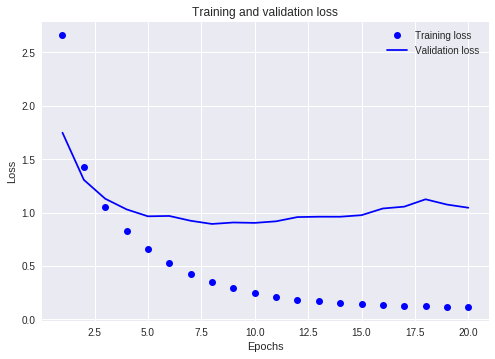

In [106]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

It seems that the network starts overfitting after 8 epochs. Let's train a new network from scratch for 8 epochs, then let's evaluate it on 
the test set:

In [0]:
from keras import models
from keras import layers
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.0005),activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.0005),activation='relu'))
l2_model.add(layers.Dense(46, activation='softmax'))

In [127]:
l2_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

l2_model_history = l2_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 271us/step - loss: 2.6049 - acc: 0.5167 - val_loss: 1.7640 - val_acc: 0.6300
Epoch 2/20
7982/7982 [==============================] - 1s 159us/step - loss: 1.4930 - acc: 0.6997 - val_loss: 1.3861 - val_acc: 0.7190
Epoch 3/20
7982/7982 [==============================] - 1s 161us/step - loss: 1.1661 - acc: 0.7711 - val_loss: 1.2671 - val_acc: 0.7360
Epoch 4/20
7982/7982 [==============================] - 1s 158us/step - loss: 0.9693 - acc: 0.8136 - val_loss: 1.1543 - val_acc: 0.7870
Epoch 5/20
7982/7982 [==============================] - 1s 160us/step - loss: 0.8214 - acc: 0.8504 - val_loss: 1.0903 - val_acc: 0.7960
Epoch 6/20
7982/7982 [==============================] - 1s 158us/step - loss: 0.7115 - acc: 0.8742 - val_loss: 1.0718 - val_acc: 0.8080
Epoch 7/20
7982/7982 [==============================] - 1s 158us/step - loss: 0.6209 - acc: 0.9004 - val_loss: 1.0484 - val_acc: 0.8090


7982/7982 [==============================] - 1s 155us/step - loss: 0.5018 - acc: 0.9255 - val_loss: 1.0489 - val_acc: 0.8120
Epoch 10/20
7982/7982 [==============================] - 1s 157us/step - loss: 0.4680 - acc: 0.9334 - val_loss: 1.0252 - val_acc: 0.8180
Epoch 11/20
7982/7982 [==============================] - 1s 158us/step - loss: 0.4368 - acc: 0.9387 - val_loss: 1.1095 - val_acc: 0.8050
Epoch 12/20
7982/7982 [==============================] - 1s 160us/step - loss: 0.4093 - acc: 0.9420 - val_loss: 1.0090 - val_acc: 0.8160
Epoch 13/20
7982/7982 [==============================] - 1s 157us/step - loss: 0.3869 - acc: 0.9483 - val_loss: 1.0120 - val_acc: 0.8130
Epoch 14/20
7982/7982 [==============================] - 1s 158us/step - loss: 0.3678 - acc: 0.9514 - val_loss: 1.0414 - val_acc: 0.8030
Epoch 15/20
7982/7982 [==============================] - 1s 163us/step - loss: 0.3631 - acc: 0.9495 - val_loss: 1.0059 - val_acc: 0.8080
Epoch 16/20
7982/7982 [==============================

7982/7982 [==============================] - 1s 161us/step - loss: 0.3371 - acc: 0.9523 - val_loss: 1.0180 - val_acc: 0.8080
Epoch 19/20
7982/7982 [==============================] - 1s 162us/step - loss: 0.3238 - acc: 0.9550 - val_loss: 1.0493 - val_acc: 0.8020
Epoch 20/20
7982/7982 [==============================] - 1s 158us/step - loss: 0.3186 - acc: 0.9548 - val_loss: 1.0343 - val_acc: 0.8200


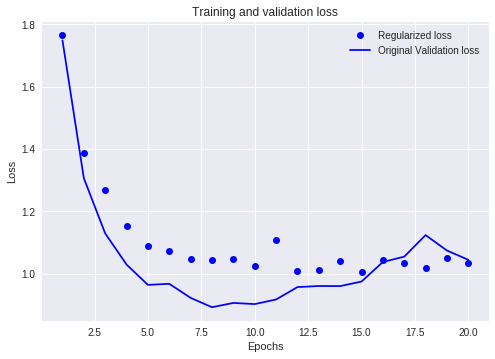

In [128]:
plt.clf()   # clear figure

l2_model_val_loss=l2_model_history.history['val_loss']
#loss=history.history['val_loss']
#plt.plot
# acc = history.history['acc']
# val_acc = history.history['val_acc']

import matplotlib.pyplot as plt

#loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, l2_model_val_loss, 'bo', label='Regularized loss')
plt.plot(epochs, val_loss, 'b', label='Original Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [131]:


l2_model_history = l2_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val))
results = l2_model.evaluate(x_test, one_hot_test_labels)
results

Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 1s 123us/step - loss: 0.2719 - acc: 0.9589 - val_loss: 1.1941 - val_acc: 0.7820
Epoch 2/10
7982/7982 [==============================] - 1s 120us/step - loss: 0.2734 - acc: 0.9573 - val_loss: 1.0616 - val_acc: 0.8010
Epoch 3/10
7982/7982 [==============================] - 1s 156us/step - loss: 0.2736 - acc: 0.9572 - val_loss: 1.0377 - val_acc: 0.8030
Epoch 4/10
7982/7982 [==============================] - 1s 161us/step - loss: 0.2700 - acc: 0.9565 - val_loss: 1.0531 - val_acc: 0.8070
Epoch 5/10
7982/7982 [==============================] - 1s 161us/step - loss: 0.2755 - acc: 0.9545 - val_loss: 1.0880 - val_acc: 0.7960
Epoch 6/10
7982/7982 [==============================] - 1s 162us/step - loss: 0.2645 - acc: 0.9585 - val_loss: 1.1196 - val_acc: 0.7970
Epoch 7/10
7982/7982 [==============================] - 1s 162us/step - loss: 0.2708 - acc: 0.9580 - val_loss: 1.0860 - val_acc: 0.7950


7982/7982 [==============================] - 1s 160us/step - loss: 0.2639 - acc: 0.9560 - val_loss: 1.0908 - val_acc: 0.7960
Epoch 10/10
2246/2246 [==============================] - 0s 183us/step


[1.2393517075960698, 0.7711487088156723]